In [1]:
import torch
from torch import nn
import numpy as np
from torch.nn import functional as F
import matplotlib.pyplot as plt

$$
\newcommand{\RR}{\mathbb{R}}
\newcommand{\ZZ}{\mathbb{Z}}
\newcommand{\CC}{\mathbb{C}}
\newcommand{\EE}{\mathbb{E}}
\newcommand{\Zz}{\mathcal{Z}}
\newcommand{\Ww}{\mathcal{W}}
\newcommand{\Vv}{\mathcal{V}}
\newcommand{\Nn}{\mathcal{N}}
\newcommand{\NN}{\mathcal{N}}
\newcommand{\Hh}{\mathcal{H}}
\newcommand{\Bb}{\mathcal{B}}
\newcommand{\Ee}{\mathcal{E}}
\newcommand{\Cc}{\mathcal{C}}
\newcommand{\Gg}{\mathcal{G}}
\newcommand{\Ss}{\mathcal{S}}
\newcommand{\Pp}{\mathcal{P}}
\newcommand{\Ff}{\mathcal{F}}
\newcommand{\Xx}{\mathcal{X}}
\newcommand{\Mm}{\mathcal{M}}
\newcommand{\Ii}{\mathcal{I}}
\newcommand{\Dd}{\mathcal{D}}
\newcommand{\Ll}{\mathcal{L}}
\newcommand{\Tt}{\mathcal{T}}
\newcommand{\al}{\alpha}
\newcommand{\la}{\lambda}
\newcommand{\ga}{\gamma}
\newcommand{\Ga}{\Gamma}
\newcommand{\La}{\Lambda}
\newcommand{\si}{\sigma}
\newcommand{\Si}{\Sigma}
\newcommand{\be}{\beta}
\newcommand{\de}{\delta}
\newcommand{\De}{\Delta}
\renewcommand{\phi}{\varphi}
\renewcommand{\th}{\theta}
\newcommand{\om}{\omega}
\newcommand{\Om}{\Omega}
\newcommand{\eps}{\varepsilon}
\newcommand{\bo}[1]{\boldsymbol{\mathbf{#1}}}
\newcommand{\bu}{\bo{u}}
\newcommand{\bv}{\bo{v}}
\newcommand{\bC}{\bo{C}}
\newcommand{\bp}{\bo{p}}
\newcommand{\bq}{\bo{q}}
\newcommand{\bX}{\bo{X}}
\newcommand{\bc}{\bo{c}}
\newcommand{\bb}{\bo{b}}
\newcommand{\bh}{\bo{h}}
\newcommand{\by}{\bo{y}}
\newcommand{\lc}{\bo{L}(\bC)}
\newcommand{\lcb}[1]{\bo{L}(\bo{#1})}
\newcommand{\ba}{\bo{a}}
\newcommand{\bbv}{\bo{b}}
\newcommand{\tD}{\bo{\widetilde{D}}}
\newcommand{\tLa}{\bo{\widetilde{\La}}}
\newcommand{\tCbe}{\bo{\widetilde{C}^{\be}}}
\newcommand{\bbe}{\bo{\beta}}
\newcommand{\Cbe}{\bC^{\bbe}}
\newcommand{\bhat}{\bo{\hat{\be}}}
\newcommand{\pibe}{\bpi^{\bbe}}
\newcommand{\bD}{\bo{D}}
\newcommand{\bZ}{\bo{Z}}
\newcommand{\bF}{\bo{F}}
\newcommand{\bA}{\bo{A}}
\newcommand{\bB}{\bo{B}}
\newcommand{\bK}{\bo{K}}
\newcommand{\bI}{\bo{I}}
\newcommand{\bS}{\bo{S}}
\newcommand{\bLa}{\bo{\La}}
\newcommand{\ctilde}{\bo{\tilde{c}}}
\newcommand{\bhatK}{\bo{\hat{K}}}
\newcommand{\bR}{\bo{R}}
\newcommand{\bAb}{\bo{\bar{A}}}
$$


# S4 in Pytorch.

## Introduction

This notebook aims at explaining the S4 layer described in [S4](https://arxiv.org/abs/2111.00396), with more details on practical use cases, as well as a simple Pytorch implementation.
Some parts of this code are directly coming from the excellent guide [Annotated S4](https://srush.github.io/annotated-s4/).

The goal of the notebook is to be as concise as possible while providing enough details for a full comprehension of a practical implementation of S4.

## Modelisation

### Classical approaches

Deep NLP has made huge progress since the arrival of the sequence-to-sequence models. A sequence-to-sequence model is a model that maps a sequence $u_0, \dots, u_{L-1}$ to another sequence $y_0, \dots, y_{L-1}$.

The main approaches in NLP were first RNN, that mimics Hidden Markov Process. In simple terms, a RNN models a situation recursively:

\begin{equation}
    \begin{cases}
        h_{k+1} &=& g(u_{k+1}, h_k),\\
        y_{k+1} &=& f(h_{k+1}).
    \end{cases}
\end{equation}
where $h_k$ represents a hidden state. Here each output $y_k$ is built recursively on the precedent value $h_{k-1}$. The main drawbacks of such models is that it is extremely difficult control how the information of previous steps flows up to the current step. It has even been derived that statistically such networks doesn't have long-memory (i.e the output at step $k$ is unlikely to have retained information of $u_{k-l}$if $l$ is large enough).

The other and currently SOTA architecture is the transformer.

Transformers are extremelly powerful because the output sequence depends directly on *all* the previous steps:

\begin{equation}
    y_{k+1} = \sum_{i=0}^{k} f(u_i, u_{k+1}).
\end{equation}

Therefore they do have long-memory. But here the problem comes form the memory consumption of such operation. To process a full sequence the memory complexity is $\mathcal{O}(L^2)$.

### State-space approach

To overcome these problems, S4 introduces the formalism of state-space models. Here $u_k \in \RR$ is a scalar input.

\begin{equation}\label{eq:state-space}
    \begin{cases}
        x_{k+1} = \bA x_k + \bb u_k,\\
        y_{k+1} = \bc^T x_{k+1}.
    \end{cases}
\end{equation}
where $x_k \in \RR^N$ is a vector and obviously $\bc \in \RR^N$. For multidimensionnal inputs, we simply apply these steps (with the same parameters) independently to all coordinates.

Let's write a first implementation of such a model.

In [2]:
class BaseSSM:
    def __init__(self, A, b, c):
        self.A = A
        self.b = b
        self.c = c

In [3]:
class SimpleSSM(BaseSSM):
    def __call__(self, u, L):

        y = torch.zeros(L)
        x_k = 0
        for i in range(L):
            x_k += b * u[i]
            y_k = self.c.T @ x_k
            y[i] = y_k
            x_k = self.A @ x_k
        return y

In [31]:
N = 10
L = 8

A = torch.randn(N, N)
b = torch.rand(N, 1)
c = torch.rand(N, 1)

In [32]:
simple_ssm = SimpleSSM(A, b, c)

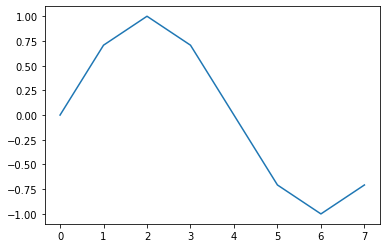

In [33]:
seq_interval = torch.arange(L)
u = torch.sin(2 * torch.pi * torch.arange(L) / L)
plt.plot(u)

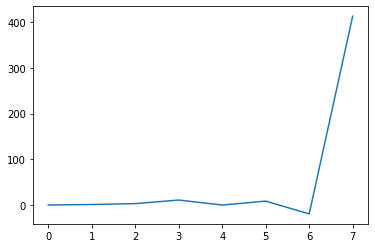

In [34]:
y = simple_ssm(u, L)
plt.plot(y)

## State-space computations

Now let's take a step back and remember that our goal is to train a model, whose parameters will include $\bA, \bb, \bc$.

However if the formulation of \eqref{eq:state-space} seems simple, it is in fact quite complicated for training, due do its recursive definition (same problems faced during training of RNN actually).

A big advantage of transformers is the possibility to process in parallel the whole sequence, that greatly improves the training speed and the backpropagation of the gradient is more easy than with recursive architectures.

Hence a legitimate question is: do we have the same property with S4? And the answer is yes!

To explain it, we are now going to focus exclusively on training, i.e when the full input and output are already available. Later, we will explain how we can generate outputs in an autoregressive manner.

## Training - Convolution view

One can notice that if we unrol \eqref{eq:state-space}, $y \in \RR^L$ can be directly expressed as a convolution between the input $u \in \RR^L$ and a filter $\bK \in \RR^L$:

\begin{align}
    y_0 &= \bc^T\bb u_0,  \dots),\\
    y_1 &= \bc^T\bA\bb u_0 + \bc^T\bb u_1,\\
    y_2 &= \bc^T \bA^2 \bb u_0 + \bc^T\bA\bb u_1 + \bc^T\bb u_2,\\
    \vdots\\
    y_k &= \sum_{i=0}^k \bc^T\bA^i\bb u_{k - i}.
\end{align}

We have therefore: $y = \bK * u$, with $\bK = \left(\bc^T \bb, \bc^T\bA\bb, \dots, \bc^T\bA^{L-1}\bb\right)$.

Good news: a convolution can be computed in $\mathcal{O}(L \log L)$ once the filter $\bK$ is known, using Discrete Fourier Transform (with padding to avoid circular convolution).

Compared to the quadratic complexity of transformers, we have a huge gain in term of memory usage.

Let's write a first function to see what it gives.

In [35]:
def k_simple(A, b, c, L):
    K = [(c.T @ A.matrix_power(l) @ b).item() for l in range(L)]
    
    # We take the real part because later we will use complex numbers.
    # But because K depends only on real values matrices, it should be real (up to floating point error on the imaginary part).
    return torch.tensor(K).real

def causal_convolution(u, K):
    convolution_shape = u.shape[0] + K.shape[0]
    
    # Specifying the paramter 'n' will automatically pad our vectors to the right dimension.
    u_fft = torch.fft.fft(u, n=convolution_shape)
    K_fft = torch.fft.fft(K, n=convolution_shape)
    out = u_fft * K_fft
    return torch.fft.ifft(out).real[: u.shape[0]]

In [37]:
class SimpleConvSSM(BaseSSM):
    
    def __call__(self, u, L):
    
        K = k_simple(self.A, self.b, self.c, L)
        y = causal_convolution(u, K)
        return y

In [38]:
simple_conv_ssm = SimpleConvSSM(A, b, c)
y_conv = simple_conv_ssm(u, L)

In [40]:
assert torch.allclose(y, y_conv, atol=1e-4)

But the main bottleneck of this computation is how we obtain the convolution kernel. We exponentiate a matrix $L$ times, compute a lot of matrix products etc, which is highly non efficient and non stable from a numerical point of view.

To make this more efficient, we can find more sophisticated algorithms.

Namely, instead of computing directly $\bK$, we are going to compute its DFT, $\bhatK$ and then simply apply a inverse Fourier Transform (IDFT). Let $\om_k = \exp\left(-{\dfrac{2i \pi k}{N}}\right)$.

\begin{align}
    \bhatK_k &= \sum_{i=0}^{L-1} \bK_i \omega_k^i,\\
    &= \sum \bc^T A^i b \omega_k^i,\\
    &= \bc^T \left(\sum \bA^i \omega_k^i \right) \bb,\\
    &= \bc^T (\bI - \bA^L)(\bI - \bA\omega_k)^{-1} \bb.
\end{align}

But this does not really reduce the complexity, because now we have to compute an inverse $L$ times (for each $\om_k$), giving a complexity of $\mathcal{O}(LN^3)$.



## HiPPO matrix

TLDR: we can assume that $\bA$ is similar to a matrix of the form $\bLa - \bp^* \bp$, where we now considerate matrix and vectors with coefficients in $\CC$.

Where $\bLa \in \CC^{N \times N}$ is diagonal and $\bp \in \CC^{N \times 1}$.
$.^*$ designated the hermitian adjoint (= transpose + conjugate) of a matrix (a vector is viewed as a matrix of $\CC^{N \times 1}$).

This decomposition is called Diagonal Plus Low Rank (DPLR).

*Remark:* In the original article the derivations are made with $\bA \sim \bLa + \bq^* \bp$. But in practice in S4 we use $\bp = \bq$ which is valid and works better for numerical reasons.

Indeed, the matrix $A$ we are using can be decomposed in the following form:
\begin{equation}
    \bA = - \dfrac{1}{2}\bI - \bS - \bp^*\bp,
\end{equation}
where $\bS$ is a skew-hermitian matrix ($\bS = - \bS^*$), and $\bp \in \RR^{N}$ is a vector of dimension 1.

And in the adapted basis, the inverse of a DLPR matrix is much more easy to compute, thanks to the Woodburry inversion formula:

\begin{equation}
    (\bLa - \bp^* \bq)^{-1} = \bLa^{-1} + \bLa^{-1}\bp \left(1 - \bq^*\bLa^{-1} \bp\right)^{-1}\bq^* \bLa^{-1}.
\end{equation}

If we apply this result to the expression of $\bhatK$, with some more algebraic operations, we obtain a quite simple formula for its expression:

\begin{equation}
    \bhatK_k = \dfrac{2}{1 + \om_k}\left[\ctilde^* \bR_k \bb - \ctilde^* \bR_k \bp (1 + \bp^*\bR_k \bp)^{-1}\bp^*\bR_k \bb\right].
\end{equation}

with $\bR_k = \left(2\dfrac{1 - \om_k}{1 + \om_k} - \bLa \right)^{-1}$ and $\ctilde^* = \bc^* (\bI - \bAb^L)$.

And here, in fact all the matrix multiplications can be evaluated very efficiently.


\begin{align}\label{eq:cauchy-K}
   \ctilde^T \bR_k \bb &= \sum_{i=1}^{N} \dfrac{\ctilde_i \bb_i}{\om_k - \bLa_i},
\end{align}

and because we want to compute it for all $\om_k$, the complexity reduces to $\mathcal{O}(NL)$.
In fact, we can be even more efficient, be we need to rely on algorithms that are not yet implemented on Pytorch.
But notice that this complexity is not a bottleneck when the biggest memory cost comes from the size of the sequence.

Computing operation \eqref{eq:cauchy-K} for all $k$ is actually a Cauchy product, a well studied problem in the litterature. We are going to implement it in a naive way, but again it won't be the main bottleneck of our model.

In [47]:
def compute_c_tilde(A, c):
    return c.T @ (torch.eye(Lambd.shape[0]) - A.matrix_power(L))

def cauchy(p, q, lambd, omega_L):
    omega_L = 2. * ((1. - omega_L) / (1 + omega_L))
    dot_product = p * q
    lambd = lambd[:, None]
    omega_L = omega_L[None, :]
    cauchy_product = dot_product / (omega_L - lambd)
    return cauchy_product.sum(axis=-2).view(-1)

def kernel_dplr(Lambd, p, b, c_tilde, L):
    omega_L = torch.exp((-2j * torch.pi) * torch.arange(L) / L)
    term_1 = cauchy(b, c_tilde, lambd, omega_L)
    term_2 = cauchy(c_tilde, p, lambd, omega_L)
    term_3 = 1. / (1. + cauchy(p.conj(), p, lambd, omega_L))
    term_4 = cauchy(p.conj(), b, lambd, omega_L)
    
    K_fft = (2. / (1. + omega_L)) * (term_1 - term_2 * term_3 * term_4) 
    return torch.fft.ifft(K_fft, L).real

In [46]:
Lambd = torch.randn(N)
p = torch.randn(N, 1)
b = torch.randn(N, 1)
c = torch.randn(N, 1)

A = torch.diag(Lambd) - p @ p.H


c_tilde = compute_c_tilde(A, c)
    

In [ ]:
K_dplr = kernel_dplr(Lambd, p, b, c_tilde) 

In [ ]:
class EfficientConvSSM(BaseSSM):
    def __init__(self, Lambd, p, b, c):
        self.Lambd = Lambd
        self.p = p
        self.b = b
        self.c = c
        

        
    def __call__(u, L):
        A = self.Lambd + p @ p.H
        c_tilde = compute_c_tilde(A, c)
        K = kernel_dplr(self.Lambd, p, b, c_tilde)
        
            

In [2]:
def hippo_init(N):
    u = torch.arange(N)
    b = torch.sqrt(2 * u[:, None] + 1)
    A = b @ b.T
    A = torch.tril(A, 0)
    A = - (A - torch.diag(u))


    return A, b

In [3]:
A, b = hippo_init(4)

In [4]:
def hippo_init_dplr(N):
    u = torch.arange(N)[:, None]
    
    p = torch.sqrt(u + 0.5)

    # Extract the skew-hermitian part of A.
    S = torch.tril(p @ p.T)
    S = - S + S.T

    # A small trick to make a skew-hermitian matrix a hermitian one.
    hermitian_S = S * -1j
    Lambda, V = torch.linalg.eigh(hermitian_S)

    # Mutliplies back the eigenvalues by (1j)^-1 to retrieve the original eigenvalues of the skew-hermitian matrix.
    # We have to add the real parts of the eigenvalues, coming for the 1/2*Id part of the decomposition. 
    Lambda = Lambda * 1j - 0.5

    # Change of basis for b and p.
    b = torch.sqrt(2 * u + 1)
    b = V.H @ b.type(torch.complex64)
    p = V.H @ p.type(torch.complex64)
    
    return V, Lambda, p, b



In [5]:
V, Lambda, p, b = hippo_init_dplr(4)

In [6]:
assert torch.allclose(V @ (torch.diag(Lambda) - p @ p.H) @ V.H, A.type(torch.complex64), atol=1e-4)

## Convolution

The naive way to make the convolution would be the following one:

In [8]:
N = 10
L = 5

In [9]:
A = torch.randn(N, N)
c = torch.randn(N, 1)
b = torch.randn(N, 1)
u = torch.randn(L)

In [10]:
K = k_conv(A, b, c, N)

In [12]:
causal_convolution(u, K)

tensor([  4.8000,   7.1977,  32.7416,   3.7354, 233.8863])

But the main bottleneck of this computation is how we obtain the convolution kernel, because we are exponentiating a matrix L time, compute a lot of matrix products etc, which is highly non efficient.

To make this more efficient, we can find more sophisticated algorithms.




Namely, instead of computing directly $\bK$, we are going to compute its spectrum, $\hat{\bK}$ and then simply apply a inverse Fourier Transform (IDFT). Let $\om_k = \exp\left(-{\dfrac{2i \pi k}{N}}\right)$.

\begin{align}
    \hat{\bK}_k &= \sum_{i=0}^{L-1} \bK_i \omega_k^i,\\
    &= \sum \bc^T A^i b \omega_k^i,\\
    &= \bc^T \left(\sum \bA^i \omega_k^i \right) \bb,\\
    &= \bc^T (\bI - \bA^L)(\bI - \bA\omega_k)^{-1} \bb.
\end{align}

But this does not really reduce the complexity, because now we have to compute an inverse $L$ times (for each $\om_k$), giving a complexity of $\mathcal{O}(LN^3)$.


However, we are lucky because we are in fact dealing with matrices that have a special form: diagonal + low-rank.

Indeed, the matrix $A$ we are using can be decomposed in the following form:
\begin{equation}
    \bA = - \dfrac{1}{2}\bI - \bS - \bp^*\bp,
\end{equation}
where $\bS$ is a skew-hermitian matrix ($\bS = - \bS^*$), and $\bp \in \RR^{N}$ is a vector of dimension 1.

And in the adapted basis, the inverse of a DLPR matrix is much more easy to compute, thanks to the Woodburry inversion formula:

\begin{equation}
    (\bLa - \bp^* \bq)^{-1} = \bLa^{-1} + \bLa^{-1}\bp \left(1 - \bq^*\bLa^{-1} \bp\right)^{-1}\bq^* \bLa^{-1}.
\end{equation}

If we apply this result to the expression of $\bhatK$, with some more algebraic operations, we obtain a quite simple formula for its expression:

\begin{equation}
    \bhatK_k = \dfrac{2}{1 + \om_k}\left[\ctilde^* \bR_k \bb - \ctilde^* \bR_k \bp (1 + \bp^*\bR_k \bp)^{-1}\bp^*\bR_k \bb\right].
\end{equation}

with $\bR_k = \left(2\dfrac{1 - \om_k}{1 + \om_k} - \bLa \right)^{-1}$ and $\ctilde^* = \bc^* (\bI - \bAb^L)$.

And here, in fact all the matrix multiplications can be evaluated very efficiently.


\begin{align}
   \ctilde^T \bR_k \bb &= \sum_{i=1}^{N} \dfrac{\ctilde_i \bb_i}{\om_k - \bLa_i},
\end{align}

and because we want to compute it for all $\om_k$, the complexity reduces to $\mathcal{O}(NL)$.
In fact, we can be even more efficient, be we need to rely on algorithms that are not yet implemented on Pytorch.
But notice that this complexity is not a bottleneck when the biggest memory cost comes from the size of the sequence.

In [13]:
def cauchy(p, q, lambd, omega_L):
    omega_L = 2. * ((1. - omega_L) / (1 + omega_L))
    dot_product = p * q
    lambd = lambd[:, None]
    omega_L = omega_L[None, :]
    cauchy_product = dot_product / (omega_L - lambd)
    return cauchy_product.sum(axis=-2).view(-1)
    

In [14]:
def kernel_dplr(lambd, b, c, p, L):
    omega_L = torch.exp((-2j * torch.pi) * torch.arange(L) / L)
    term_1 = cauchy(b, c.conj(), lambd, omega_L)
    term_2 = cauchy(c.conj(), p, lambd, omega_L)
    term_3 = 1. / (1. + cauchy(p.conj(), p, lambd, omega_L))
    term_4 = cauchy(p.conj(), b, lambd, omega_L)
    
    K_fft = (2. / (1. + omega_L)) * (term_1 - term_2 * term_3 * term_4) 
    return torch.fft.ifft(K_fft, L).real

In [15]:
def k_gen_simple(A, b, c, L):
    K = k_conv(A, b, c, L)
    def gen(z):
        return torch.sum(K *  z ** torch.arange(L))
    return gen

In [16]:
def k_gen_inverse(A, b, ct, L):
    I = torch.eye(A.shape[0])
    A_L = A.matrix_power(L)
    return lambda z: (ct.H @ torch.linalg.inv(I - A * z) @ b)

In [17]:
def conv_from_gen(A, b, c, L, inv=False):
    if not inv:
        gen = k_gen_simple(A, b, c, L)
    else:
        gen = k_gen_inverse(A, b, c, L)
    omega_L = torch.exp((-2j * torch.pi) * torch.arange(L) / L)
    at_roots = torch.tensor([gen(z) for z in omega_L])
    out = torch.fft.ifft(at_roots, L).reshape(L)
    return out

In [18]:
def discretize(A, b, c, step=1):
    I = torch.eye(A.shape[0])
    b_left = torch.linalg.inv(I - (step / 2.0) * A)
    A_bar = b_left @ (I + (step / 2.0) * A)
    b_bar = (b_left * step) @ b
    return A_bar, b_bar, c

In [19]:
def test_conv_kernel(L=10, N=20):
    
    V, Lambda, p, b = hippo_init_dplr(N)
    A = torch.diag(Lambda) - p @ p.H
    c = torch.randn(N, 1).type(torch.complex64)
    c_basis_diag = V.H @ c.type(torch.complex64)
    A_bar, b_bar, c_bar = discretize(A, b, c_basis_diag)
    c_tilde_h = c_bar.T @ (torch.eye(N) - A_bar.matrix_power(L))
    c_tilde = c_tilde_h.H
    K_simple = k_conv(A_bar, b_bar, c_bar, L)
    K_efficient = kernel_dplr(Lambda, b, c_tilde, p, L)

    assert torch.allclose(K_simple, K_efficient, atol=1e-4)
    
    u = torch.randn(L)
    
    y_simple = causal_convolution(u, K_simple)
    y_efficient = causal_convolution(u, K_efficient)
    assert torch.allclose(y_simple, y_efficient, atol=1e-4)

In [20]:
test_conv_kernel()

In [21]:
def multidimensional_input_simple(u, K):
    out = torch.zeros_like(u)
    for i in range(u.shape[0]):
        for j in range(u.shape[-1]):
            out[i, :, j] = causal_convolution(u[i, :, j], K)
    return out

In [22]:
def causal_convolution_n(u, K):
    K = K[None, :, None]
    fft_shape = u.shape[1] + K.shape[1]
    u_fft = torch.fft.fft(u, n=fft_shape, axis=1)
    K_fft = torch.fft.fft(K, n=fft_shape, axis=1)
    out = u_fft * K_fft
    return torch.fft.ifft(out, axis=1)[:, :u.shape[1], :].real
    

In [23]:
def test_multidimensional_convolution(batch_size=8, seq_length=10, hidden_size=5):
    u = torch.randn(batch_size, seq_length, hidden_size)
    K = torch.randn(seq_length)
    simple_conv = multidimensional_input_simple(u, K)
    efficient_conv = causal_convolution_n(u, K)
    assert torch.allclose(efficient_conv, simple_conv)

In [24]:
test_multidimensional_convolution()

## Recurrent decoding

In a situation of unsupervised generation, we need to be able to compute the state space equation autoregressively.
But hopefully, thanks to the parametrization of $\bA$ as a NPLR matrix, we can compute a recurrence step in $\mathcal{O}(NH)$ where $H$ is the hidden dimension and $N$ the polynomial space dimension.

In [25]:
def discrete_dplr(Lambda, p, b, c, L, step=1.):
    # Convert parameters to matrices
    b = b

    N = Lambda.shape[0]
    A = torch.diag(Lambda) - p @ p.H
    I = torch.eye(N)

    # Forward Euler
    A0 = (2.0 / step) * I + A

    # Backward Euler
    D = torch.diag(1.0 / ((2.0 / step) - Lambda))
    Dp = D @ p
    
    A1 = D - (Dp * (1.0 / (1 + (p.H @ Dp))) * p.H @ D)

    # A bar and B bar
    A_bar = A1 @ A0
    b_bar = 2 * A1 @ b

    return A_bar, b_bar

In [26]:
def scan_ssm(Ab, Bb, Cb, u, x0):
    def step(x_k_1, u_k):
        x_k = Ab @ x_k_1 + Bb @ u_k
        y_k = Cb @ x_k
        return x_k, y_k
    recurrence = []
    x_k = x0
    for i in range(u.shape[0]):
        x_k, y_k = step(x_k, u[i])
        recurrence.append(y_k)
    return x_k, torch.tensor(recurrence).real

In [27]:
def test_conversion(N=8, L=16):
    V, Lambda, p, b = hippo_init_dplr(N)
    A = torch.diag(Lambda) - p @ p.H
    c = torch.randn(N, 1).type(torch.complex64)
    c_basis_diag = V.H @ c.type(torch.complex64)
    A_bar, b_bar, c_bar = discretize(A, b, c_basis_diag)
    c_tilde_h = c_bar.T @ (torch.eye(N) - A_bar.matrix_power(L))
    c_tilde = c_tilde_h.H

    # CNN form.
    K = kernel_dplr(Lambda, b, c_tilde, p, L)

    # RNN form.
    Ab, Bb = discrete_dplr(Lambda, p, b, c, L)
    K2 = k_conv(A_bar, b_bar, c_bar, L=L)
    assert np.allclose(K, K2, atol=1e-5, rtol=1e-5)

    # Apply CNN
    u = torch.arange(L).type(torch.complex64)
    y1 = causal_convolution(u, K)

    # Apply RNN
    _, y2 = scan_ssm(
        Ab, Bb, c_bar.T, u[:, np.newaxis], torch.zeros((N,)).type(torch.complex64)
    )
    assert np.allclose(y1, y2.reshape(-1).real, atol=1e-4, rtol=1e-4)

In [28]:
test_conversion()